#  Basic use 2: Human to mouse

Here is a brief demonstration on how to use TransBrain to map the phenptype from human to mouse. The example data used in this tutorial can be download from ``exampledata`` directory of our [GitHub repository](https://github.com/ibpshangzheng/transbrain/tree/main/transbrain/exampledata).

## Step 1: Prepare input data

There are two ways to input data. One is that you already have region-level phenotype data as a ``CSV`` table which follows the format and region order in the [provided template file](https://github.com/ibpshangzheng/transbrain/tree/main/transbrain/exampledata). The DataFrame contains two columns: ``['Anatomical Name', 'Phenotype']``.

Here we load the example human data table.

In [1]:
import pandas as pd

# Example human data
human_phenotype = pd.read_csv('../../../transbrain/exampledata/human/bn/human_bn_all_example_data.csv',index_col=0)

In [2]:
human_phenotype

Phenotype
Anatomical Name           
A8m               0.260696
A8dl             -0.132093
A9l              -0.841146
A6dl              0.151087
A6m               0.614044
...                    ...
Otha              2.237752
mPFtha            2.532931
lPFtha            2.300108
rTtha             2.957160
PPtha             1.973803

[127 rows x 1 columns]

Or if you data is volumetric data in ``.nii`` or ``.nii.gz`` format that has been aligned to the human atlas space. You can use the following functions to extract region-level data. 
When fetching atlas, you need to choose the region_type parameter from {'cortex', 'subcortex', 'all'}, which controls the regions to include in returned region names and info table.

In [3]:
import transbrain as tb

help(tb.atlas.fetch_human_atlas)

Help on function fetch_human_atlas in module transbrain.atlas:

fetch_human_atlas(atlas_type: Literal['bn', 'dk', 'aal'] = 'bn', region_type: Literal['cortex', 'subcortex', 'all'] = 'all')
    Fetch a human brain atlas image and its region information.
    
    This function loads a labeled brain atlas image (e.g., Brainnetome, Desikan-Killiany, or AAL) 
    along with its corresponding ROI (region of interest) metadata table.
    
    Parameters
    ----------
    atlas_type : {'bn', 'dk', 'aal'}, optional
        The type of atlas to load. Must be one of:
        - 'bn'  : Brainnetome Atlas
        - 'dk'  : Desikan-Killiany Atlas
        - 'aal' : Automated Anatomical Labeling (AAL) Atlas
        Default is 'bn'.
    
    region_type : {'cortex', 'subcortex', 'all'}, optional
        Which regions to include in returned region names and info table: cortical, subcortical, or all. Default is 'all'.
    
    Returns
    -------
    dict
        A dictionary with the following keys:
   

In [4]:
#Fetch human atlas
human_atlas = tb.atlas.fetch_human_atlas(atlas_type='bn',region_type='all')

In [5]:
human_atlas.keys()

dict_keys(['atlas', 'atlas_data', 'region_info', 'info_table'])

The first two items in the returned dictionary are the NIfTI file of the atlas and the array in it, while the next two items store the brain region names and a table containing label values.

In [6]:
human_atlas['info_table']

Anatomical Name  Atlas Index
0               A8m            1
1              A8dl            2
2               A9l            3
3              A6dl            4
4               A6m            5
..              ...          ...
122           rTtha          123
123           PPtha          124
124            Otha          125
125           cTtha          126
126          lPFtha          127

[127 rows x 2 columns]

Next, we use the `get_region_phenotypes` function to calculate regional phenotype data from the image. In addition to the phenotype image and the atlas dictionary, you also need to specify the atlas name and the regions to be extracted.

In [7]:
help(tb.base.get_region_phenotypes)

Help on function get_region_phenotypes in module transbrain.base:

get_region_phenotypes(phenotype_nii_path: str, atlas_dict: dict, atlas_type: Literal['bn', 'dk', 'aal', 'mouse'] = 'bn', region_type: Literal['cortex', 'subcortex', 'all'] = 'all', method: str = 'mean', resample: bool = True, label_column: str = 'Atlas Index', region_column: str = 'Anatomical Name') -> pandas.core.frame.DataFrame
    Calculate region-wise phenotype values using a specified brain atlas.
    
    This function extracts regional statistics (mean or sum) from a phenotype NIfTI image 
    based on a chosen human or mouse brain atlas. The atlas can be automatically 
    resampled to match the phenotype image resolution if needed.
    
    Parameters
    ----------
    phenotype_nii_path : str
        Path to the input phenotype NIfTI file. Should be in MNI space for human atlases,
        or Allen CCFv3 space for mouse atlas.
    atlas_dict : dict
        A dictionary containing the following keys:
    
     

In [8]:
# Get phenotypes in Human atlas used in TransBrain
phenotype_nii_path = '../../../transbrain/exampledata/human/human_example_phenotype_data.nii.gz'
human_phenotype_extracted = tb.base.get_region_phenotypes(phenotype_nii_path, atlas_dict = human_atlas, atlas_type='bn', region_type='all')

In [9]:
human_phenotype_extracted

Phenotype
Anatomical Name           
A8m               0.260747
A8dl             -0.132129
A9l              -0.841126
A6dl              0.151081
A6m               0.614070
...                    ...
Otha              2.237802
mPFtha            2.532970
lPFtha            2.300147
rTtha             2.957121
PPtha             1.973806

[127 rows x 1 columns]

### Visualizing human phenotype data

Using visualization function of TransBrain to view the data.

In [10]:
from transbrain.vis import map_phenotype_to_nifti, plot_human_phenotype

# map the region-level phenotype data to an image
phenotype_img = map_phenotype_to_nifti(human_phenotype, human_atlas)

<Figure size 3000x300 with 0 Axes>

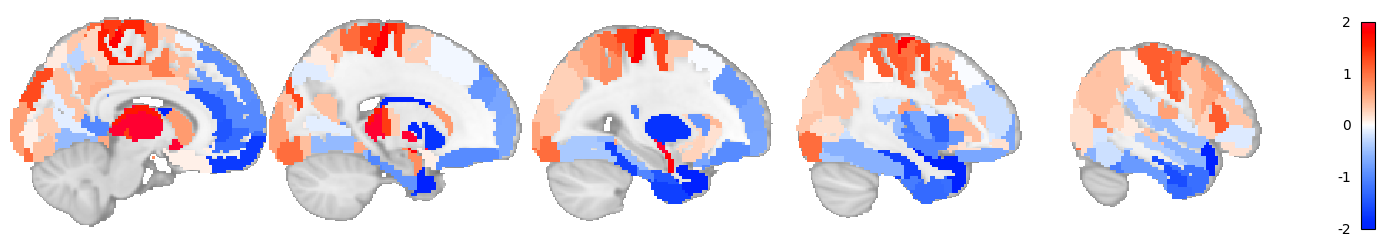

In [11]:
# view the image
plot_human_phenotype(phenotype_img, normalize_img=True, cut_coords=range(10, 60, 10), vmax=2, symmetric_cbar = True)

## Step 2: Initialization
Before starting the mapping, you need to initialize TransBrain by creating an instance of the ``SpeciesTrans`` class.

You need to specify which human brain atlas space you want to map from to the mouse brain. You can choose ``atlas_type`` from ``['bn', 'dk', 'aal']``. During this process, TransBrain will automatically load the necessary information for the mapping, including the brain region name list and the graph embedding matrix for the selected atlas.

In [12]:
#Initialize TransBrain for bn atlas
Transformer = tb.trans.SpeciesTrans('bn')

INFO:root:Initialized for bn atlas.


## Step 3: Mapping

Now, we can map the human phenotype DataFrame (either loaded or extracted) to mouse brain, you need to choose the regions to map and whether to normalize the data. This step is enabled by default. If your data has already been normalized, you can set it to False.

In [13]:
help(Transformer.human_to_mouse)

Help on method human_to_mouse in module transbrain.trans:

human_to_mouse(phenotype: pandas.core.frame.DataFrame, region_type: Literal['cortex', 'subcortex', 'all'] = 'cortex', normalize: bool = True, restore: bool = False) -> pandas.core.frame.DataFrame method of transbrain.trans.SpeciesTrans instance
    Translate human phenotype to mouse.
    
    Parameters
    ----------
    phenotype : pd.DataFrame
        Human phenotype DataFrame (regions × phenotypes).
    region_type : {'cortex', 'subcortex', 'all'}, optional
        The brain region type to translate. Default is 'cortex'.
    normalize : bool, optional
        Whether to normalize data before translation. Default is True.
    restore : bool, optional
        Whether to restore values back to original scale after translation. Only used if normalize is True.
        Please enable this parameter with caution, unless you are certain that the distributions of this phenotype are consistent between the two species.
    
    Returns

In [14]:
# Example from human to mouse
human_phenotype_in_mouse = Transformer.human_to_mouse(
                                        human_phenotype_extracted, 
                                        region_type='all', 
                                        normalize=True
                                        )

INFO:root:Successfully translated human all phenotypes to mouse.


Once the mapping is complete, you will see a success message. Let's take a look at the mapped data. Now, you got the DataFrame that stores the phenotype data corresponding to the mouse CCFv3 atlas.

In [15]:
human_phenotype_in_mouse

Phenotype
ACAd    0.296682
ACAv    0.303369
PL      0.327434
ILA     0.332395
ORBl    0.386486
...          ...
GENv    0.638572
EPI     0.731165
RT      0.640975
MOs     0.434217
VISam   0.389529

[68 rows x 1 columns]

You can also visualize what the mapped data looks like on mouse brain.

In [16]:
from transbrain.vis import plot_mouse_phenotype

#Fetch mouse atlas
mouse_atlas = tb.atlas.fetch_mouse_atlas(region_type='all')

# map the region-level phenotype data to an image
mapped_phenotype_img = map_phenotype_to_nifti(human_phenotype_in_mouse, mouse_atlas)

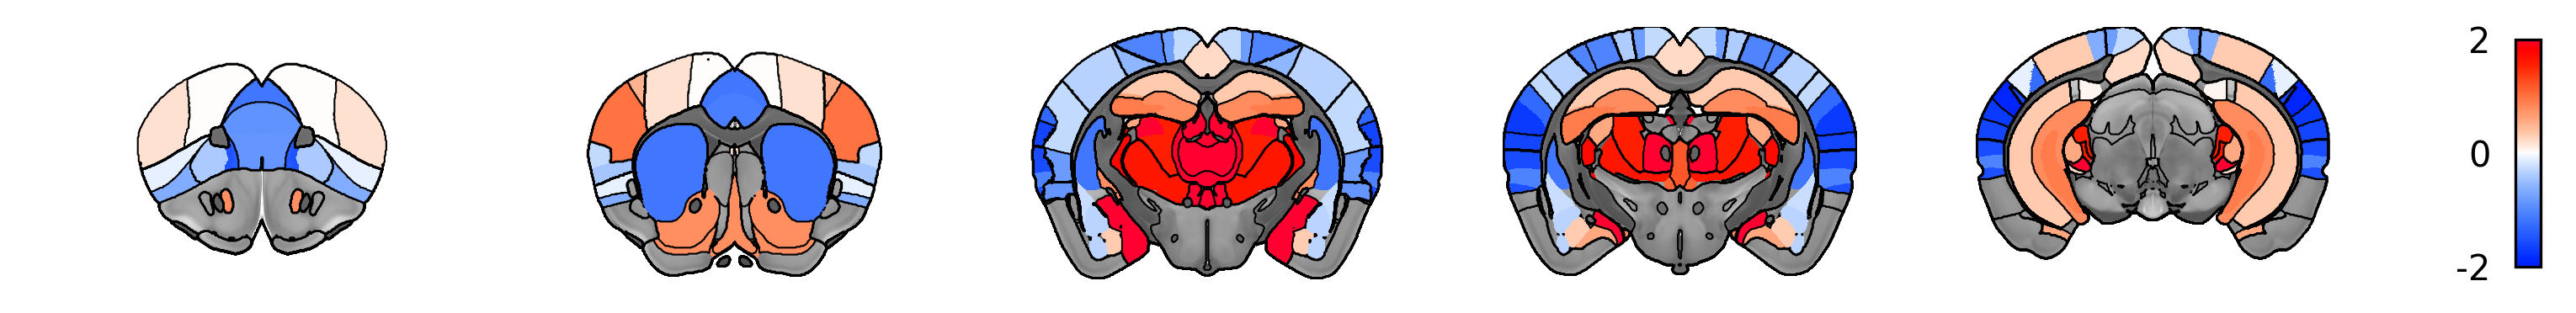

In [17]:
# view the image
plot_mouse_phenotype(mapped_phenotype_img, normalize_img=True, symmetric_cbar=True,vmax=2, threshold=0)